In [1]:
using CSV
using JuMP, Ipopt
using MosekTools 
using Gurobi
using DataFrames #, IndexedTables
using CSV
using LinearAlgebra
using Plots#, PlotlyJS
using Statistics
using Plots
using Random


In [2]:
df = DataFrame(CSV.File("baseline_all.csv"));
first(df, 2)

Row,Column1,year,amt,cma,sma,p_cma,p_sma,balance_cma,balance_sma,state
,Int64,Int64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,String
1,0,1975,17954.0,17954.0,missing,missing,missing,missing,missing,MD
2,1,1976,0.0,8977.0,missing,17954.0,missing,0.0,missing,MD


In [3]:
#number of states
N = length(unique(df.state)); 
#number of years 
T = length(unique(df.year)); 

state_list = unique(df.state);
time_list = unique(df.year);
print(state_list[4])

FL

In [4]:
#amount matrix
M_amt = Matrix{Float64}(undef,N,T); 

#construct M_amt: where i, t = loss at state i in time t 
i=1
for state in state_list
    M_amt[i,:] = df[df.state .== state, "amt"] 
    i+=1 
end 

In [5]:
#construct premium baseline 
#baseline premium for final 10 years 
P_base = Matrix{Float64}(undef,N,10); 

#construct P_base: where i, t = premium using CMA at state i in time t 
i=1
for state in state_list
    P_base[i,:] = df[df.state .== state, "p_cma"][end-9:end] #final 10 years of premium 
    i+=1 
end 

In [6]:
size(M_amt)
act_loss = M_amt[:,end-9:end]; 

In [7]:
#construct P_hist: actual policies
#load actual policy premiums 
df_policy = DataFrame(CSV.File("nfip_premium_agg.csv"));
#policy data is from 2010-2022 
year_list = range(2010, 2022)
#amount matrix
P_hist= Matrix{Float32}(undef,N,length(year_list)); 

i =1
for state in state_list
    t = 1 
    for year in year_list 
        premium = df_policy[(df_policy.propertyState .== state ).& (df_policy.year .== year) , "sum"]
        if length(premium)==1
            P_hist[i,t] = premium[1]
        else 
            println(state, year, "missing")
            P_hist[i, t] = 0  
        end 
        t+=1 
    end 
    i+=1 
end 

UT2010missing
UT2011missing
SD2010missing
SD2011missing
SD2013missing
VI2012missing
VI2013missing
WY2021missing


In [8]:
#
#compute the historical mean and variance up to 10 years  
M_hist = M_amt[:, 1:end-10]; 
std_hist = std(M_hist, dims=2); #std_hist[i,t] = state i at year t 
mean_hist = mean(M_hist, dims=2); 

In [9]:
#how do I recover P, and l? 
function recover_P(i, alpha, beta)
    act_loss = M_amt[:,end-9:end];  
    T1 = 10 
    P_i = Matrix{Float64}(undef,1,T1); 
    P_i[1] = alpha[1]
    for t=2:T1
        P_i[t] = alpha[t] + sum(beta[tao] * act_loss[i, tao] for tao=1:t-1)
    end 
    return P_i 
end 

recover_P (generic function with 1 method)

In [15]:
#new recover P, for solve_aro3, i.e., P = alpha_it + beta_it*l_it-1
function recover_P3(i, alpha, beta)
    act_loss = M_amt[:,end-9:end];  
    T1 = 10 
    P_i = Matrix{Float64}(undef,1,T1); 
    P_i[1] = alpha[1]
    for t=2:T1
        P_i[t] = alpha[t] + beta[t-1] * act_loss[i, t-1] 
    end 
    return P_i 
end 

recover_P3 (generic function with 1 method)

## Solving ARO 




In [31]:
#attempt 2 of solving ARO: slowly vary alpha instead of P
# so that beta cannot all be 0 
i=3 
gamma2 = 0.8

function solve_aro3(i, gamma2)
gamma1 = 1e5  
T= 10 
delta = 1e5 #this is surplus 

#for now let's solve it for one state i 
c1 =  T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T) #c1 is a vector, where c1[i] is the ith state value 
c2 = -T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T)
println(c1, c2)


#try decompose into small models 
println(c1, c2)
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", 300)


# VARIABLES: premium for the next 10 years 
@variable(model, alpha[1:T]);  #P_i,t is the premium at state i in time t 
@variable(model, beta[1:(T-1)]);

@variable(model, omega); 

#simplifying: forcing all alpha to be the same 
# for t=2:T
# @constraint(model, alpha[t] == alpha[1]); 
# end 

# (1) Epigraph formulation of the objective value 
@objective(model, Min, omega)

@variable(model, s11>=0);
@variable(model, s12>=0);

@constraint(model, epigraph, 
    sum(alpha[t] for t = 1:T) + (c1*s11+c2*s12)  <= omega ); 

for t=1:(T-1)
    @constraint(model, 
        s11-s12 >= beta[t]);  
end 

@constraint(model, s11 - s12 >=0); 

# (2) surplus constraint 
@variable(model, s21>=0);
@variable(model, s22>=0);

@constraint(model, surplus, 
    -sum(alpha[t] for t = 1:T) + (c1*s21+c2*s22)  <= -delta); 

for t=1:(T-1) 
    @constraint(model, 
        s21-s22 >= 1-beta[t]);  
end 
# @constraint(model, 
#         s21-s22 >= 1); # this is creating problem, double check this, related to obj function T or T-1  
    


# # surplus constraint 2 
# TT= 5
# @variable(model, ss21>=0);
# @variable(model, ss22>=0);

# @constraint(model, 
#     -sum(alpha[t] for t = 1:TT) + (c1*ss21+c2*ss22)  <= -delta); 

# for t=1:(TT-1) 
#     @constraint(model, 
#         ss21-ss22 >= 1-(TT-t)*beta[t]);  
# end 
# @constraint(model, 
#         ss21-ss22 >= 1);    
    
# surplus constraint, for all T' in T_list : this is not working 
# T_list = [5, 10]
# global T_list 
# T_size = length(T_list)
# @variable(model, s21[1:T_size]>=0);
# @variable(model, s22[1:T_size]>=0);

# for j = 1:T_size 
#     TT = T_list[j]
#     @constraint(model,
#         -sum(alpha[t] for t = 1:TT) + (c1*s21[j]+c2*s22[j])  <= -delta );  

#     for tt=1:(TT-1)
#         @constraint(model, 
#             s21[j]-s22[j] >= 1-(TT-tt)*beta[tt]);  
#     end 
# #     @constraint(model, s21[j] - s22[j] >=1); 
#     @constraint(model, s21[j] - s22[j] >=0); 
# end 

# (3) slowly varying constraints: on alpha 
for t=2:T
    @constraint(model, 
        alpha[t] - alpha[t-1] <= gamma1 ) 
    @constraint(model, 
        alpha[t] - alpha[t-1] >= -gamma1)
end    

# (4) positive l_i constraint 
@variable(model, s51[2:T] >=0)
@variable(model, s52[2:T] >=0)

for t=2:T
    @constraint(model, 
        -alpha[t] + (c1*s51[t]+c2*s52[t]) <= 0 ) 
    for tao = 1:(t-1)
        @constraint(model, s51[t] - s52[t] >= -beta[tao])
        @constraint(model, s51[t] - s52[t] >= 0)
    end 
end 

@constraint(model, alpha[1]>=0)
@constraint(model, alpha[1] == mean_hist[i]) #force alpha 1 = historical alpha 
# for t = 1:T
#     @constraint(model, alpha[t] == mean_hist[i])
# end 

optimize!(model)
    # println(termination_status(model))
    # alpha = value.(alpha)
    # beta = value.(beta)
    # print(alpha, beta)
    println(value.(s21), value.(s22))
    
    return value.(alpha), value.(beta)
end 


solve_aro3 (generic function with 1 method)

In [32]:
i=4
gamma2=0.8
a,b = solve_aro3(i, gamma2)
# P_i = recover_P(i, a, b)
P_i = recover_P3(i, a, b)

# T_list=[5,10]
T_list=[10]
println("alpha = ", a )
println("beta = ", b)
println("P_i = ", P_i)
println("'sum'", sum(P_i))


1.2425519399780014e9-2.9706038948515636e8
1.2425519399780014e9-2.9706038948515636e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xf2d24496
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.2426519e+09   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds
Optimal objective 

In [17]:
i=4
gamma2=0.8
a,b = solve_aro3(i, gamma2)
# P_i = recover_P(i, a, b)
P_i = recover_P3(i, a, b)

# T_list=[5,10]
T_list=[10]
println("alpha = ", a )
println("beta = ", b)
println("P_i = ", P_i)
println("'sum'", sum(P_i))


1.2425519399780014e9-2.9706038948515636e8
1.2425519399780014e9-2.9706038948515636e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x9c5bcb60
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      19    1.2426519e+09   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds
Optimal objective 

In [81]:
# #attempt 2 of solving ARO: slowly vary alpha instead of P
# # so that beta cannot all be 0 
# i=3 
# gamma2 = 0

# function solve_aro2(i, gamma2)
# gamma1 = 1e5 
# T= 10 
# delta = 1e5 #this is surplus 

# #for now let's solve it for one state i 
# c1 =  T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T) #c1 is a vector, where c1[i] is the ith state value 
# c2 = -T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T)
# println(c1, c2)


# #try decompose into small models 
# println(c1, c2)
# model = Model(Gurobi.Optimizer)
# set_optimizer_attribute(model, "TimeLimit", 300)


# # VARIABLES: premium for the next 10 years 
# @variable(model, alpha[1:T]);  #P_i,t is the premium at state i in time t 
# @variable(model, beta[1:(T-1)]);

# @variable(model, omega); 

# #simplifying: forcing all alpha to be the same 
# # for t=2:T
# # @constraint(model, alpha[t] == alpha[1]); 
# # end 

# # (1) Epigraph formulation of the objective value 
# @objective(model, Min, omega)

# @variable(model, s11>=0);
# @variable(model, s12>=0);

# @constraint(model, epigraph, 
#     sum(alpha[t] for t = 1:T) + (c1*s11+c2*s12)  <= omega ); 

# for t=1:(T-1)
#     @constraint(model, 
#         s11-s12 >= (T-t)*beta[t]);  
# end 

# @constraint(model, s11 - s12 >=0); 

# # (2) surplus constraint 
# @variable(model, s21>=0);
# @variable(model, s22>=0);

# @constraint(model, surplus, 
#     -sum(alpha[t] for t = 1:T) + (c1*s21+c2*s22)  <= -delta); 

# for t=1:(T-1) 
#     @constraint(model, 
#         s21-s22 >= 1-(T-t)*beta[t]);  
# end 
# # @constraint(model, 
# #         s21-s22 >= 1); #Q: or >=1? double check this  
    
# # # surplus constraint 2 
# # TT= 5
# # @variable(model, ss21>=0);
# # @variable(model, ss22>=0);

# # @constraint(model, 
# #     -sum(alpha[t] for t = 1:TT) + (c1*ss21+c2*ss22)  <= -delta); 

# # for t=1:(TT-1) 
# #     @constraint(model, 
# #         ss21-ss22 >= 1-(TT-t)*beta[t]);  
# # end 
# # @constraint(model, 
# #         ss21-ss22 >= 1);    
    
# # surplus constraint, for all T' in T_list : this is not working 
# # T_list = [5, 10]
# # global T_list 
# # T_size = length(T_list)
# # @variable(model, s21[1:T_size]>=0);
# # @variable(model, s22[1:T_size]>=0);

# # for j = 1:T_size 
# #     TT = T_list[j]
# #     @constraint(model,
# #         -sum(alpha[t] for t = 1:TT) + (c1*s21[j]+c2*s22[j])  <= -delta );  

# #     for tt=1:(TT-1)
# #         @constraint(model, 
# #             s21[j]-s22[j] >= 1-(TT-tt)*beta[tt]);  
# #     end 
# # #     @constraint(model, s21[j] - s22[j] >=1); 
# #     @constraint(model, s21[j] - s22[j] >=0); 
# # end 

# # (3) slowly varying constraints: on alpha 
# for t=2:T
#     @constraint(model, 
#         alpha[t] - alpha[t-1] <= gamma1 ) 
#     @constraint(model, 
#         alpha[t] - alpha[t-1] >= -gamma1)
# end    

# # (4) positive l_i constraint 
# @variable(model, s51[2:T] >=0)
# @variable(model, s52[2:T] >=0)

# for t=2:T
#     @constraint(model, 
#         -alpha[t] + (c1*s51[t]+c2*s52[t]) <= 0 ) 
#     for tao = 1:(t-1)
#         @constraint(model, s51[t] - s52[t] >= -beta[tao])
#         @constraint(model, s51[t] - s52[t] >= 0)
#     end 
# end 

# @constraint(model, alpha[1]>=0)
# @constraint(model, alpha[1] == mean_hist[i]) #force alpha 1 = historical alpha 
# # for t = 1:T
# #     @constraint(model, alpha[t] == mean_hist[i])
# # end 

# optimize!(model)
#     # println(termination_status(model))
#     # alpha = value.(alpha)
#     # beta = value.(beta)
#     # print(alpha, beta)
#     println(value.(s21), value.(s22))
    
#     return value.(alpha), value.(beta)
# end 


In [82]:
# i=4
# gamma2=0.0000001
# a,b = solve_aro2(i, gamma2)
# P_i = recover_P(i, a, b)
# # T_list=[5,10]
# T_list=[10]
# println("alpha = ", a )
# println("beta = ", b)
# println("P_i = ", P_i)
# println("'sum'", sum(P_i))


In [19]:
#solve it for all states 
T1= 10 
gamma2 = 0.8 

P_aro = Matrix{Float64}(undef,N,T1); 
Beta = Matrix{Float64}(undef,N,T1-1);  
Alpha = Matrix{Float64}(undef,N,T1);   
for i=1:N 
    alpha_i, beta_i = solve_aro3(i, gamma2); 
    Beta[i,:] = beta_i; 
    Alpha[i,:] = alpha_i; 
    P_aro[i,:] = recover_P3(i, alpha_i, beta_i); 
end 

1.1460303646754543e81.413757930703327e6
1.1460303646754543e81.413757930703327e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x68be527f
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       9    1.1470304e+08   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  1.14

0.72792495356606690.0
1.2747380493505797e8-4.0726162159678854e7
1.2747380493505797e8-4.0726162159678854e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x76b15c62
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      18    1.2757380e+08   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seco

0.67907950203792820.0
1.3850367004616652e91.9458819394587553e8
1.3850367004616652e91.9458819394587553e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x62f340ae
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      10    1.3851367e+09   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 second

0.70254538980555550.0
4.483315157685147e7-5.03673100735905e6
4.483315157685147e7-5.03673100735905e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x02961a4b
Coefficient statistics:
  Matrix range     [1e+00, 4e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.9186826e+34   5.647635e+30   4.918683e+04      0s
      20    4.4933152e+07   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  4.493315158e+07

User-callback calls 60, time in user-callback 0.00 sec
0.59297507217475550

0.56464075533924780.0
2.9761327259654805e7-4.1168028929767758e6
2.9761327259654805e7-4.1168028929767758e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0x116a57c4
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0203153e+34   5.142222e+30   4.020315e+04      0s
      21    2.9861327e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds
Optimal objective  2.986132726e+07

User-callback calls 62, time in user-callback 0.00 sec
0.62460470644

0.7398681672268580.0
602707.2778836392-186833.50632688715
602707.2778836392-186833.50632688715
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xd830a459
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 120 rows and 25 columns
Presolve time: 0.00s
Presolved: 20 rows, 25 columns, 77 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8245460e+33   5.197710e+30   1.824546e+03      0s
       9    7.0270728e+05   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  7.027072779e+05

User-callback calls 50, time in user-callback 0.00 sec
0.130999046001723880.0


In [22]:
#let's experiment how Beta and Alpha changes with different gamma2: 
#varying gamma2 

state_i = 5 #state i 

gamma2_ls = range(start=0, step =0.2, stop=1) 
avg_beta_ls = Array{Float64}(undef,length(gamma2_ls));
surplus_ls = Array{Float64}(undef,length(gamma2_ls));
avg_alpha_ls = Array{Float64}(undef,length(gamma2_ls)); 

j=1 
for gamma2 in gamma2_ls
    alpha_i, beta_i = solve_aro3(state_i, gamma2); 
    P_aro_i = recover_P3(i, alpha_i, beta_i); 
    s = sum(P_aro_i)-sum(act_loss)
    surplus_ls[j] = s 
    avg_alpha_ls[j] = mean(alpha_i)
    avg_beta_ls[j] = mean(beta_i)
    j+=1 
end  


9.873962474210525e7-9.873962474210525e7
9.873962474210525e7-9.873962474210525e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 140 rows, 42 columns and 371 nonzeros
Model fingerprint: 0xcb594a5e
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+07]
Presolve removed 130 rows and 31 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    9.8839625e+07   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  9.883962474e+07

User-callback calls 50, time in user-callback 0.00 sec
0.99949361768256080.0
1.309791061274336

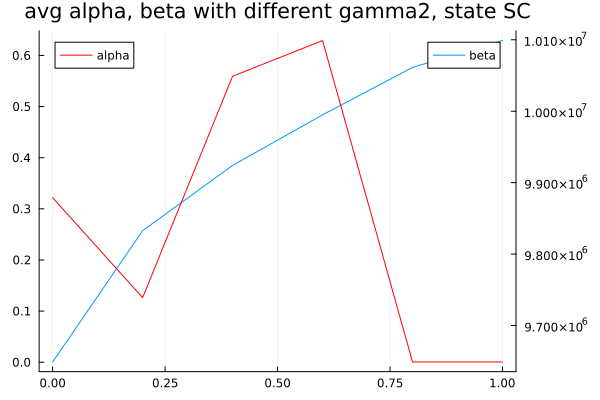

In [23]:
#plot different gamma2 leading to different surplus 
# DataFrame(hcat(gamma2_ls, surplus_ls), [:"Gamma2",:"Surplus"]); 
plot(gamma2_ls,avg_beta_ls, title="avg alpha, beta with different gamma2, state $(state_list[state_i])", 
    label="beta",legend=:topright)
plot!(twinx(), gamma2_ls, avg_alpha_ls, color=:red, xticks=:none,
    label="alpha",legend=:topleft)


In [24]:
Beta[i,:]

9-element Vector{Float64}:
 0.3791356804406607
 0.3791356804406607
 0.3791356804406607
 0.3791356804406607
 0.3791356804406607
 0.3791356804406607
 0.3791356804406607
 0.3791356804406607
 0.3791356804406607

In [25]:
P_aro[i,:]

10-element Vector{Float64}:
 7.698061647315788e7
 8.821871125436291e7
 1.1483014033365773e8
 8.606999993916814e7
 1.692920676497842e8
 4.1567468099258953e8
 1.555194380411428e8
 8.936615965377924e7
 2.230054385132519e8
 8.478699632176e7

In [26]:
#call solve ro (function below)
T_list = [10]
P_ro = solve_ro(gamma2)
print(P_ro[1,:])

LoadError: UndefVarError: solve_ro not defined

sum ARO, sum RO, sum act = 5.535622261134916e97.808812639581051e93.79003212392e9
beta=[0.5656046581101888, 0.5656046581101888, 0.5656046581101888, 0.5656046581101888, 0.5656046581101888, 0.5656046581101888, 0.5656046581101888, 0.5656046581101888, 0.5656046581101888]


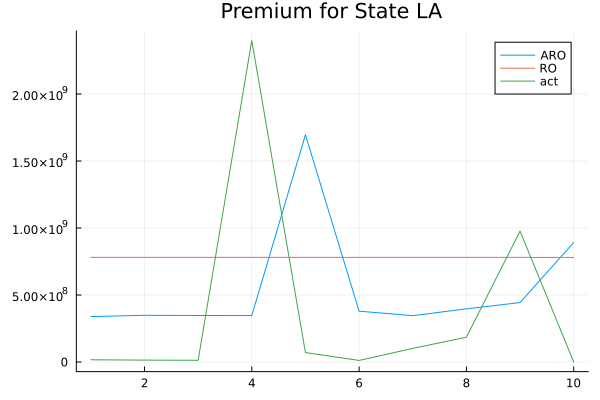

In [30]:
i=12
println("sum ARO, sum RO, sum act = ", sum(P_aro[i, :]), sum(P_ro[i,:]), sum(M_amt[i,end-9:end]))
println("beta=", Beta[i,:])
plot(range(1,10,10), [P_aro[i, :],P_ro[i,:],M_amt[i,end-9:end]], 
    title="Premium for State $(state_list[i])", 
    label=["ARO" "RO" "act"])



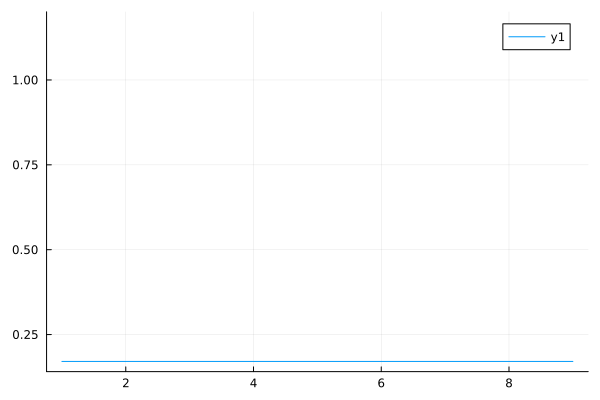

In [115]:
plot(Beta[i,:])

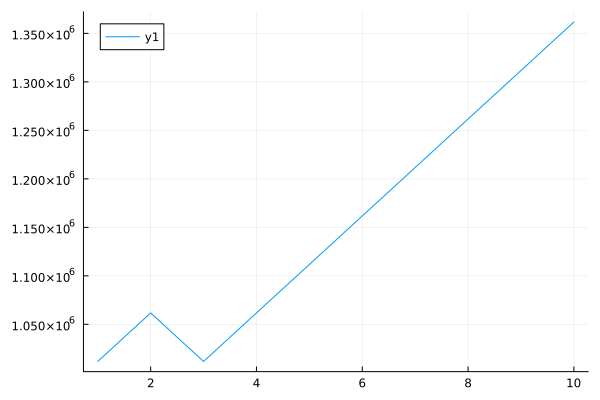

In [116]:
plot(Alpha[i,:])

In [697]:
i=3 
gamma2 = 0

function solve_aro(i, gamma2)
gamma1 = 5e7 
T= 10 
delta = 1e5 #this is surplus 

#for now let's solve it for one state i 
c1 =  T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T) #c1 is a vector, where c1[i] is the ith state value 
c2 = -T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T)
println(c1, c2)


#try decompose into small models 
println(c1, c2)
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", 300)


# VARIABLES: premium for the next 10 years 
@variable(model, alpha[1:T]);  #P_i,t is the premium at state i in time t 
@variable(model, beta[1:(T-1)]);

@variable(model, omega); 

#simplifying: forcing all alpha to be the same 
for t=2:T
@constraint(model, alpha[t] == alpha[1]); 
end 

#Epigraph formulation of the objective value 
@objective(model, Min, omega)

@variable(model, s11>=0);
@variable(model, s12>=0);

@constraint(model, epigraph, 
    sum(alpha[t] for t = 1:T) + (c1*s11+c2*s12)  <= omega ); 

for t=1:(T-1)
    @constraint(model, 
        s11-s12 >= (T-t)*beta[t]);  
end 

@constraint(model, s11 - s12 >=0); 

# surplus constraint 
# @variable(model, s21>=0);
# @variable(model, s22>=0);

# @constraint(model, surplus, 
#     -sum(alpha[t] for t = 1:T) + (c1*s21+c2*s22)  <= -delta); 

# for t=1:(T-1) 
#     @constraint(model, 
#         s21-s22 >= 1-(T-t)*beta[t]);  
# end 
# @constraint(model, 
#         s21-s22 >= 1);
    
# # surplus constraint 2 
# TT= 5
# @variable(model, ss21>=0);
# @variable(model, ss22>=0);

# @constraint(model, 
#     -sum(alpha[t] for t = 1:TT) + (c1*ss21+c2*ss22)  <= -delta); 

# for t=1:(TT-1) 
#     @constraint(model, 
#         ss21-ss22 >= 1-(TT-t)*beta[t]);  
# end 
# @constraint(model, 
#         ss21-ss22 >= 1);    
    
# surplus constraint, for all T' in T_list : this is not working 
# T_list = [5, 10]
global T_list 
T_size = length(T_list)
@variable(model, s21[1:T_size]>=0);
@variable(model, s22[1:T_size]>=0);

for j = 1:T_size 
    TT = T_list[j]
    @constraint(model,
        -sum(alpha[t] for t = 1:TT) + (c1*s21[j]+c2*s22[j])  <= -delta );  

    for tt=1:(TT-1)
        @constraint(model, 
            s21[j]-s22[j] >= 1-(TT-tt)*beta[tt]);  
    end 
    @constraint(model, s21[j] - s22[j] >=1); 
    @constraint(model, s21[j] - s22[j] >=0); 
end 

#slowly varying constraints 
#for some t, and hence S1, S2 are vectors of size T 
@variable(model, s31[2:T] >=0)
@variable(model, s32[2:T] >=0)

for t=2:T
    @constraint(model,
        alpha[t] - alpha[t-1] + (c1*s31[t]+c2*s32[t]) <= gamma1 ) 
    @constraint(model,
        s31[t] - s32[t] >= beta[t-1])
    @constraint(model,
        s31[t] - s32[t] >= 0)
end 

#slowly varying 2 
@variable(model, s41[2:T] >=0)
@variable(model, s42[2:T] >=0)

for t=2:T 
    @constraint(model,
        -(alpha[t] - alpha[t-1]) + (c1*s41[t]+c2*s42[t]) <= gamma1 ) 
    @constraint(model,
        s41[t] - s42[t] >= -beta[t-1])
    @constraint(model,
        s41[t] - s42[t] >= 0)
end 

# positive l_i constraint 
@variable(model, s51[2:T] >=0)
@variable(model, s52[2:T] >=0)

for t=2:T
    @constraint(model, 
        -alpha[t] + (c1*s51[t]+c2*s52[t]) <= 0 ) 
    for tao = 1:(t-1)
        @constraint(model, s51[t] - s52[t] >= -beta[tao])
        @constraint(model, s51[t] - s52[t] >= 0)
    end 
end 

@constraint(model, alpha[1]>=0)

optimize!(model)
    # println(termination_status(model))
    # alpha = value.(alpha)
    # beta = value.(beta)
    # print(alpha, beta)
    println(value.(s21), value.(s22))
    
    return value.(alpha), value.(beta)
end 

solve_aro (generic function with 1 method)

In [698]:
i=3
gamma2=0.0000001
T_list = [5,10]
a,b = solve_aro(i, gamma2)
P_i = recover_P(i, a, b)
println("alpha = ", a )
println("beta = ", b)
println("P_i = ", P_i)
println("'sum'", sum(P_i))

1.1033226339839127e9-1.103322442573982e9
1.1033226339839127e9-1.103322442573982e9
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 193 rows, 80 columns and 541 nonzeros
Model fingerprint: 0x27a24e16
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 160 rows and 69 columns
Presolve time: 0.00s
Presolved: 33 rows, 18 columns, 87 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.932660e+05   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
       4    2.2068453e+09   0.000000e+00   0.000000e+00      0s

Solved in 4 iterati

In [722]:
#simplified ARO formulation 
function solve_aro_simple(i, gamma2)
gamma1 = 1e5 
T= 10 
delta = 1e5 #this is surplus 

#for now let's solve it for one state i 
c1 =  T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T) #c1 is a vector, where c1[i] is the ith state value 
c2 = -T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T)
println(c1, c2)


#try decompose into small models 
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", 300)


# VARIABLES: premium for the next 10 years 
@variable(model, alpha>=0);  #P_i,t is the premium at state i in time t 
@variable(model, beta[1:(T-1)]);

@variable(model, omega); 


##Epigraph formulation of the objective value 
@objective(model, Min, omega)

@variable(model, s11>=0);
@variable(model, s12>=0);

@constraint(model, epigraph, 
    T*alpha + (c1*s11+c2*s12)  <= omega ); 

for t=1:(T-1)
    @constraint(model, 
        s11-s12 >= beta[t]);  
end 

@constraint(model, s11 - s12 >=0); 

##surplus constraint: this doesn't seem to be working 
@variable(model, s21>=0);
@variable(model, s22>=0);

@constraint(model, surplus, 
    -T*alpha + (c1*s21+c2*s22)  <= -delta); 

for t=1:(T-1) 
    @constraint(model, 
        s21-s22 >= 1-beta[t]);  
end 
@constraint(model, 
        s21-s22 >=1); 

optimize!(model)
    # println(termination_status(model))
    # alpha = value.(alpha)
    # beta = value.(beta)
    # print(alpha, beta)
    println(value.(s21), value.(s22))
    
    return value.(alpha), value.(beta)
end 

solve_aro_simple (generic function with 1 method)

In [723]:
i=3
gamma2= 0
T_list = [5,10]
a,b = solve_aro_simple(i, gamma2)
# P_i = recover_P(i, a, b)
# println("alpha = ", a )
# println("beta = ", b)
# println("P_i = ", P_i)
# println("'sum'", sum(P_i))
println(a, b)

#I think the problem is tuning the parameter values and then beta will be eventually non-zero 

110332.25382789475-110332.25382789475
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 22 rows, 15 columns and 65 nonzeros
Model fingerprint: 0x4b1da9a3
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 22 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1033225e+05   0.000000e+00   2.154927e+02      0s
Extra simplex iterations after uncrush: 1
       1    2.1033225e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  2.103322538e+05

User-callback calls 34, time in user-callback 0.00 sec
1.00.0
21033.225382789475[0.0, 0.0, 0.0, 0.0, 0.0

In [676]:
#debug solving deterministic model:
# if I put gamma2 = 0 for the above, I should get the same results 
function solve_aro_determ(i)
gamma1 = 50000 
T1= 10 
surplus = 1000 #this is delta 
l_i = mean_hist[i]

model2 = Model(Gurobi.Optimizer)
set_optimizer_attribute(model2, "TimeLimit", 300)


# VARIABLES: premium for the next 10 years 
@variable(model2, p_i[1:T1]>=0);  #P_i,t is the premium at state i in time t 


#Epigraph formulation of the objective value 
@objective(model2, Min, sum(p_i[t] for t = 1:T1))

#surplus 
@constraint(model2, sum(p_i[t] for t = 1:T1) -  l_i*T1 >=surplus )

#surplus altnerative over list of T:
global T_list 
for TT in T_list 
    @constraint(model2, sum(p_i[t] for t = 1:5) -  l_i*TT >=surplus )
end 

@constraint(model2, slowly_vary[t=2:T1], p_i[t] - p_i[t-1] <= gamma1)
@constraint(model2, slowly_vary2[t=2:T1], p_i[t-1] - p_i[t] <= gamma1)

optimize!(model2)
    return value.(p_i)
end 

solve_aro_determ (generic function with 1 method)

In [677]:
#check: if we get zero then it's good 
i=1 
P_i_determ = solve_aro_determ(i)
a, b  = solve_aro(i, 0) #gamma2 = 0 
P_i = recover_P(i, a, b)
println("difference between deterministic and aro with gamma2 = 0: ", 
    P_i[:] - P_i_determ[:]) 

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 21 rows, 10 columns and 56 nonzeros
Model fingerprint: 0xffdba90b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 6e+07]
Presolve removed 10 rows and 0 columns
Presolve time: 0.00s
Presolved: 11 rows, 19 columns, 42 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.131913e+08   0.000000e+00      0s
      12    1.1194128e+08   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds
Optimal objective  1.119412785e+08

User-callback calls 42, time in user-callback 0.00 sec
5.6594639268421054e7-5.6594639268421054e7
5.6594639268421054e7-5.6594639268421054e7
Academic license - for non-commercial u

In [654]:
#observe that as gamma2 increases, the sum of insurance premium increases too 
i=17 
gamma2_ls = [0, 0.2, 0.4, 0.6, 0.8, 1]
P_i_ls = Matrix{Float64}(undef, length(gamma2_ls),T); 

for j = 1:length(gamma2_ls)
    gamma2 = gamma2_ls[j]
    a, b = solve_aro(i, gamma2)
    P_i = recover_P(i, a, b) 
    P_i_ls[j,:] = P_i #record P_i_ls 
end 
# println(P_i_ls)

1.2245031825421052e9-1.2245031825421052e9
1.2245031825421052e9-1.2245031825421052e9
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 204 rows, 82 columns and 580 nonzeros
Model fingerprint: 0x7fa8a39c
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 166 rows and 71 columns
Presolve time: 0.00s
Presolved: 38 rows, 11 columns, 73 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0404236e+09   5.352133e+01   0.000000e+00      0s
       7    2.0408403e+09   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.00 seconds
Optimal objective  

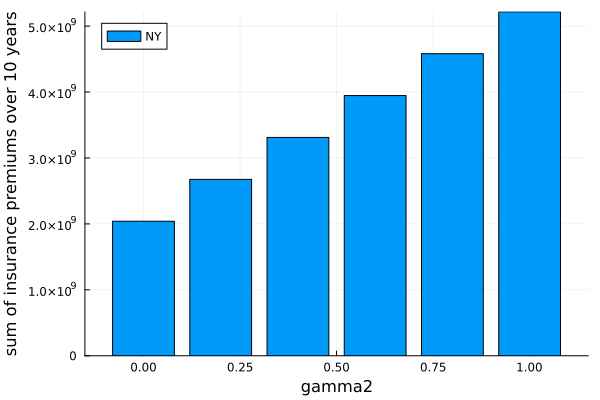

In [655]:
#plot 
state_i = state_list[i]
sums = sum(P_i_ls[:,t] for t = 1:T)
p = bar(gamma2_ls, sums, label="$(state_i)")
xlabel!("gamma2")
ylabel!("sum of insurance premiums over 10 years")
# savefig(p,"figs_insur/aro_vary_gamma2_$(state_i).png")

In [656]:
#Putting everything together to solve for P for all states 
T=10 
gamma2 = 0.5 
T_list = [6,8,10]

P_aro = Matrix{Float64}(undef,N,T); 
Beta = Matrix{Float64}(undef,N,T-1);  
Alpha = Matrix{Float64}(undef,N,T);   

for i=1:N 
    println(i)
    alpha_i, beta_i = solve_aro(i, gamma2); 
    Beta[i,:] = beta_i; 
    Alpha[i,:] = alpha_i; 
    P_aro[i,:] = recover_P(i, alpha_i, beta_i); 
end 

#compare with solve_RO no adaptive 
P_ro = solve_ro(gamma2)

1
9.28498875178738e7-2.0339391018968314e7
9.28498875178738e7-2.0339391018968314e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 204 rows, 82 columns and 580 nonzeros
Model fingerprint: 0x7f889881
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 204 rows and 82 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5475148e+08   0.000000e+00   3.972537e+04      0s
Extra simplex iterations after uncrush: 1
       1    1.5475148e+08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  1.547514792e+08

User-callback calls 37, time in user-callback 0.00 sec
[1

[1.0, 1.3333334814324058, 1.6666669628648114][0.0, 0.0, 0.0]
10
7.039306473922582e7-4.143587056077416e7
7.039306473922582e7-4.143587056077416e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 204 rows, 82 columns and 580 nonzeros
Model fingerprint: 0xc8e15e73
Coefficient statistics:
  Matrix range     [1e+00, 7e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 204 rows and 82 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1732344e+08   0.000000e+00   8.092943e+04      0s
Extra simplex iterations after uncrush: 1
       1    1.1732344e+08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  1.173234412e

[1.0, 1.333335211093195, 1.6666704221863904][0.0, 0.0, 0.0]
19
9.769802382512882e7-3.6489279748555414e7
9.769802382512882e7-3.6489279748555414e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 204 rows, 82 columns and 580 nonzeros
Model fingerprint: 0x3c833919
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 204 rows and 82 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6283171e+08   0.000000e+00   7.126812e+04      0s
Extra simplex iterations after uncrush: 1
       1    1.6283171e+08   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  1.628317064

1.2339292678379964e7-4.700132826883193e6
1.2339292678379964e7-4.700132826883193e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 204 rows, 82 columns and 580 nonzeros
Model fingerprint: 0xa43f84cf
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 204 rows and 82 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0567154e+07   0.000000e+00   9.179947e+03      0s
Extra simplex iterations after uncrush: 1
       1    2.0567154e+07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  2.056715446e+07

User-callback calls 37, time in user-callback 0.00 sec
[1

[1.0, 1.3333362067797965, 1.6666724135595927][0.0, 0.0, 0.0]
38
3.235818853051575e6-2.109717220632637e6
3.235818853051575e6-2.109717220632637e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 204 rows, 82 columns and 580 nonzeros
Model fingerprint: 0xb7549161
Coefficient statistics:
  Matrix range     [1e+00, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 204 rows and 82 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3946981e+06   0.000000e+00   4.120541e+03      0s
Extra simplex iterations after uncrush: 1
       1    5.3946981e+06   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  5.394698088e

[1.0, 1.3336226113809648, 1.6672452227619297][0.0, 0.0, 0.0]
48
2.7070047922187097e7-2.1318029567602705e6
2.7070047922187097e7-2.1318029567602705e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 204 rows, 82 columns and 580 nonzeros
Model fingerprint: 0x8992b02d
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 204 rows and 82 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5118413e+07   0.000000e+00   4.163678e+03      0s
Extra simplex iterations after uncrush: 1
       1    4.5118413e+07   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  4.511841

53×10 Matrix{Float64}:
      1.04652e7       1.04152e7  …       1.00652e7       1.00152e7
 526962.0        476962.0           269415.0        319415.0
      1.72235e8       1.72185e8          1.71835e8       1.71785e8
      1.1525e8        1.152e8            1.1485e8        1.148e8
      2.04044e7       2.03544e7          2.00044e7       1.99544e7
      2.04885e7       2.04385e7  …       2.00885e7       2.00385e7
      1.44626e6       1.39626e6          1.10921e6       1.15921e6
      3.13505e7       3.13005e7          3.09505e7       3.09005e7
      2.52749e8       2.52699e8          2.52349e8       2.52299e8
      7.58579e6       7.53579e6          7.18579e6       7.13579e6
      1.20349e7       1.19849e7  …       1.16349e7       1.15849e7
      6.95702e8       6.95652e8          6.95302e8       6.95252e8
      1.73461e7       1.72961e7          1.69461e7       1.68961e7
      ⋮                          ⋱                  
      2.85367e6       2.80367e6          2.45367e6       2.40

state = MD


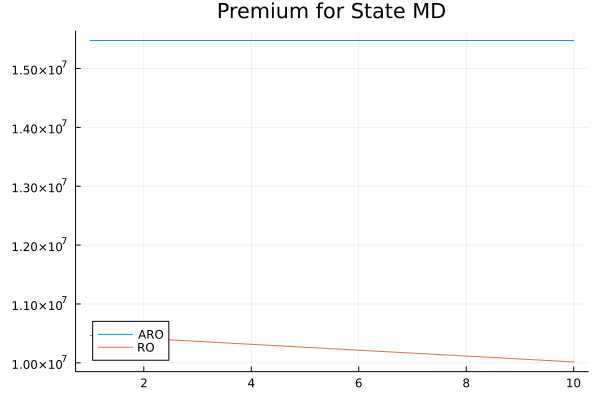

In [658]:
#plot the amount 
i= 1
println("state = ",state_list[i])

plot(range(1,10,10), [P_aro[i,:], P_ro[i,:]], title="Premium for State $(state_list[i])", label=["ARO" "RO"])

#in general the ARO approach requires less premium at the earlier years, than RO approach.
#this is because we are able to respond later on. 

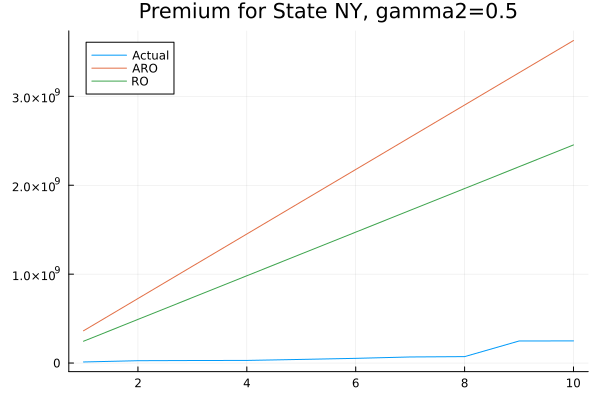

In [569]:
plot(range(1,10,10), 
    [cumsum(act_loss[i,:]), cumsum(P_aro[i,:]), cumsum(P_ro[i,:])], 
    title="Premium for State $(state_list[i]), gamma2=$(gamma2)", label=["Actual" "ARO" "RO"])
# savefig(p,"figs_insur/cumsum_$(gamma2)_$(state_list[i]).png")

10-element Vector{Float64}:
 2.933824162084454e9
 5.865098324168908e9
 8.793722486253363e9
 1.1719796648337816e10
 1.464322081042227e10
 1.756401982631758e10
 2.048216884221289e10
 2.3397750642456104e10
 2.6310782442699314e10
 2.9221351007616367e10

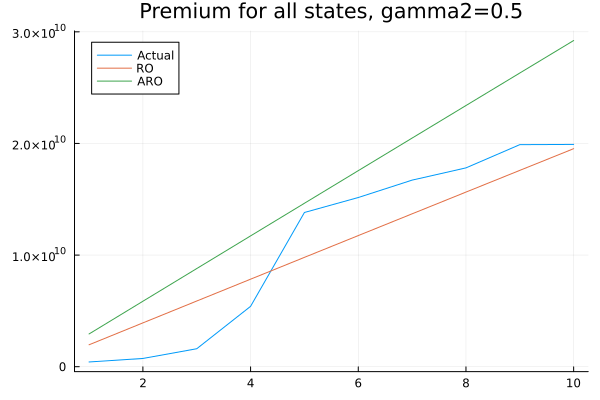

In [643]:
plot(range(1,10,10), 
    [cumsum(sum(act_loss[i,:] for i=1:N)), 
        cumsum(sum(P_ro[i,:] for i=1:N)),
        cumsum(sum(P_aro[i,:] for i=1:N))], 
    title="Premium for all states, gamma2=$(gamma2)", label=["Actual" "RO" "ARO"])
# savefig(p,"figs_insur/cumsum_$(gamma2)_allstate.png")

In [570]:
#comparisons of the first 5 years of premium for various states 
T_end = 5 
act_sum = sum(act_loss[:,t] for t=1:T_end)
ro_sum= sum(P_ro[:,t] for t=1:T_end)
aro_sum = sum(P_aro[:,t] for t=1:T_end)

results = [act_sum[:] ro_sum[:] aro_sum[:]]
# compute the sum 
sums = sum(results, dims=1)
results = [results; sums]
df = DataFrame(results ,:auto)
insertcols!(df,1, :states =>[state_list; "Total"])
new_column_names = [:State, :Atual, :RO, :ARO]
rename!(df, new_column_names)

Row,State,Atual,RO,ARO
,String,Float64,Float64,Float64
1,MD,1.74249e7,5.18258e7,7.75007e7
2,MT,6.74972e5,2.13481e6,3.03286e6
3,TX,8.16283e9,8.60674e8,1.31833e9
4,FL,1.28854e9,5.75751e8,8.87853e8
5,SC,3.3501e8,1.01522e8,1.49574e8
6,VA,8.29403e7,1.01943e8,1.56516e8
7,MI,2.54508e7,6.73132e6,1.04905e7
8,NC,2.13632e8,1.56253e8,2.42471e8
9,NJ,3.48391e7,1.26324e9,1.87575e9


In [618]:
#compare sums over different time steps 
act_sums = Array{Float64}(undef, length(T_end_ls))
ro_sums = Array{Float64}(undef, length(T_end_ls))
aro_sums = Array{Float64}(undef, length(T_end_ls))

T_end_ls = [5,8,10] 

for j = 1:length(T_end_ls)
T_end = T_end_ls[j]
act_sums[j] = sum(act_loss[i,t] for t=1:T_end for i=1:N)
ro_sums[j] = sum(P_ro[i,t] for t=1:T_end for i=1:N)
aro_sums[j]= sum(P_aro[i,t] for t=1:T_end for i=1:N)
end 
# groupedbar([act_sums, ro_sums], bar_position = :dodge, bar_width=0.5)

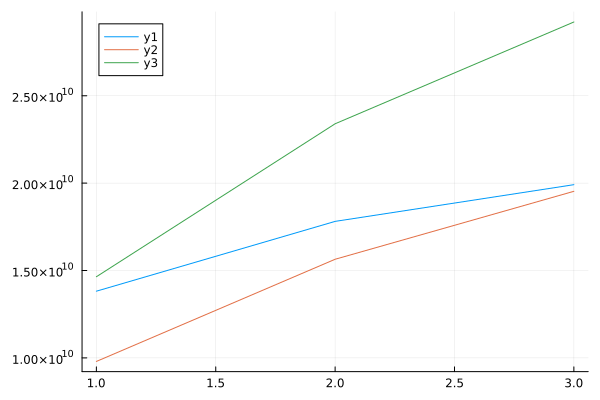

In [617]:
plot([act_sums, ro_sums, aro_sums], bar_position = :dodge, bar_width=0.5)

In [175]:
# P_i = recover_P(i, alpha, beta)
# println(P_i)
# P_i[3] - P_i[2]

In [185]:
# P_aro[i,:] - P_ro[i,:]

In [187]:
# sum(P_aro)

In [27]:
#not Adaptive, just RO 
function solve_ro(gamma2)
        gamma1 = 50000 
        T = 10 
        surplus = 1000 #this is delta 
    
#         #gamma determines L_star
#         L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 

        model3 = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model3, "TimeLimit", 30)

        # VARIABLES: premium for the next 10 years 
        @variable(model3, P[1:N,1:T] >=0);  #P_i,t is the premium at state i in time t 
    
        # each state premium covers state loss L* from the inner problem 
#         T_list = [5, 10]
        global T_list 
        T_size = length(T_list)
        for TT in T_list
            L_star_TT =  TT*mean_hist + gamma2*std_hist*sqrt(TT)
            for i=1:N 
                @constraint(model3,
                    sum(P[i, t] for t = 1:TT) - L_star_TT[i] >= surplus); 
            end 
        end

        #slowly vary 
        @constraint(model3, slowly_vary[i=1:N, t=2:T],
            P[i,t] - P[i, t-1] <= gamma1);
        @constraint(model3, slowly_vary2[i=1:N, t=2:T],
            P[i,t-1] - P[i, t] <= gamma1)

        @objective(
                model3, Min, sum(P[i, t] for t = 1:T, i = 1:N) 
            )

        optimize!(model3)
        P_ro = value.(P);   
    return P_ro 
end 

solve_ro (generic function with 1 method)

In [28]:
T_list = [10]
P_ro = solve_ro(gamma2)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1007 rows, 530 columns and 2438 nonzeros
Model fingerprint: 0x10f6291f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 477 rows and 0 columns
Presolve time: 0.00s
Presolved: 530 rows, 1007 columns, 1961 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.171590e+10   0.000000e+00      0s
     528    2.1715902e+10   0.000000e+00   0.000000e+00      0s

Solved in 528 iterations and 0.01 seconds
Optimal objective  2.171590198e+10

User-callback calls 558, time in user-callback 0.00 sec


53×10 Matrix{Float64}:
 1.16554e7      1.16054e7  1.15554e7  …       1.13554e7  1.14054e7
 5.93112e5      5.43112e5  4.93112e5          2.93112e5  2.43112e5
 1.87121e8      1.87071e8  1.87021e8          1.86721e8  1.86671e8
 1.2448e8       1.2443e8   1.2438e8           1.2408e8   1.2403e8
 2.29949e7      2.29449e7  2.28949e7          2.25949e7  2.25449e7
 2.22739e7      2.22239e7  2.21739e7  …       2.18739e7  2.19239e7
 1.60806e6      1.55806e6  1.50806e6          1.20806e6  1.15806e6
 3.3697e7       3.3647e7   3.3597e7           3.3397e7   3.3447e7
 2.82102e8      2.82052e8  2.82002e8          2.81702e8  2.81652e8
 8.07312e6      8.02312e6  7.97312e6          7.87312e6  7.92312e6
 1.29725e7      1.29225e7  1.28725e7  …       1.25725e7  1.25225e7
 7.81106e8      7.81056e8  7.81006e8          7.80706e8  7.80656e8
 1.8794e7       1.8744e7   1.8694e7           1.8394e7   1.8444e7
 ⋮                                    ⋱                  
 3.20123e6      3.15123e6  3.10123e6          2.801

In [473]:
# plot(P_ro[i,:]

In [33]:
# alpha, beta = solve_aro(1)
alpha = JuMP.value.(alpha)
beta = JuMP.value.(beta)
T1 = 10 
P_i = Matrix{Float64}(undef,1,T1); 
P_i[1] = alpha[1]
for t=2:T1
    P_i[t] = alpha[t] + sum(beta[t2] * l_i[t2] for t2=1:t-1)
end 
println("alpha", alpha)
println("beta", beta)
println(P_i)
plot(x= range(1, 10, 10) , P_i[:])
# alpha, beta = solve_aro(1)

In [13]:
P_i[4]-P_i[3]

50000.0

In [14]:
sum(P_i), sum(l_i)

(2.3366244921052633e6, 2.335624492105263e6)

In [34]:
#debug solving deterministic model 
i=2 

gamma2 = 0
gamma1 = 50000 
T1= 10 
surplus = 1000 #this is delta 

model2 = Model(Gurobi.Optimizer)
set_optimizer_attribute(model2, "TimeLimit", 300)


# VARIABLES: premium for the next 10 years 
@variable(model2, p_i[1:T1]>=0);  #P_i,t is the premium at state i in time t 


#Epigraph formulation of the objective value 
@objective(model2, Min, sum(p_i[t] for t = 1:T1))

@constraint(model2, sum(p_i[t] for t = 1:T1) -  sum(l_i[t] for t = 1:T1) >=surplus )
@constraint(model2, slowly_vary[t=2:T1], p_i[t] - p_i[t-1] <= gamma1)
@constraint(model2, slowly_vary2[t=2:T1], p_i[t-1] - p_i[t] <= gamma1)

optimize!(model2)
p_i2 = JuMP.value.(p_i)

Academic license - for non-commercial use only - expires 2024-04-04


LoadError: UndefVarError: l_i not defined

[8662.44921052628 58662.449210526276 108662.44921052628 158662.44921052628 208662.44921052628 258662.44921052628 308662.4492105263 358662.4492105263 408662.4492105263 458662.4492105263]
[458662.44921052625, 408662.44921052625, 358662.44921052625, 308662.44921052625, 258662.44921052625, 208662.44921052625, 158662.44921052625, 108662.44921052625, 58662.44921052625, 8662.449210526247]


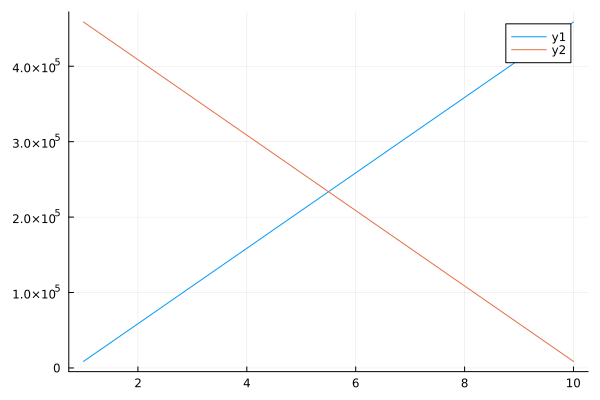

In [25]:
#debug to see if I get deterministic outcome with gamma2 = 0 
println(P_i)
println(p_i2)
#it's the same except for reversed 
plot(x= range(1, 10, 10) , [P_i[:], p_i2[:]])
`

## Debug by solving individual RC
- conclusion: each individual RC gives correct min-max duality (no gap) 
- it seems that the last constriant (5) forces the betas to be zero 

In [325]:
#initialization 
i=2 
T = 10 
gamma2 = 0.8 
beta = rand(9)*0.1  #random beta of small numbers 
alpha = rand(10)*1006 

c1 =  T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T) #c1 is a vector, where c1[i] is the ith state value 
c2 = -T*mean_hist[i] + gamma2*std_hist[i]*sqrt(T)


-491131.8515443725

In [326]:
#(1) epigraph formulation: original formulation 

ro1 = Model(Gurobi.Optimizer)
set_optimizer_attribute(ro1, "TimeLimit", 300)
@variable(ro1, l[1:T]>=0)
@objective(ro1, Max, sum((T-t)*beta[t]*l[t] for t=1:(T-1)))
@constraint(ro1, sum(l[t] for t=1:T) - mean_hist[i]*T <= std_hist[i]*gamma2*sqrt(T))
@constraint(ro1, sum(l[t] for t=1:T) - mean_hist[i]*T >= -std_hist[i]*gamma2*sqrt(T))

optimize!(ro1)
objective_value.(ro1)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x3efb5e03
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+05, 4e+06]
Presolve removed 2 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7805751e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.780575086e+06

User-callback calls 27, time in user-callback 0.00 sec


1.7805750860834352e6

In [327]:
#Robust counter part 
rc1 = Model(Gurobi.Optimizer)
set_optimizer_attribute(rc1, "TimeLimit", 300)

@variable(rc1, s[1:2]>=0)
@objective(rc1, Min, sum(c1*s[1] + c2*s[2])) 
    for t=1:(T-1)
        @constraint(rc1, s[1] - s[2] >= (T-t)*beta[t]) 
    end 

optimize!(rc1)
objective_value.(rc1) 

println("gap in ro and rc = ", objective_value.(rc1)  - objective_value.(ro1))

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9 rows, 2 columns and 18 nonzeros
Model fingerprint: 0x2b24da47
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+05, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 4e-01]
Presolve removed 9 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7805751e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.780575086e+06

User-callback calls 28, time in user-callback 0.00 sec
gap in ro and rc = 0.0


In [375]:
#(2) surplus formulation: original formulation 

ro2 = Model(Gurobi.Optimizer)
set_optimizer_attribute(ro2, "TimeLimit", 300)
@variable(ro2, l[1:T]>=0)

# @objective(ro2, Max, sum(l[t] for t=1:T)-sum((T-t)*beta[t]*l[t] for t=1:(T-1)))
@objective(ro2, Max, -sum(((T-t)*beta[t]-1)*l[t] for t=1:(T-1)))

@constraint(ro2, sum(l[t] for t=1:T) - mean_hist[i]*T <= std_hist[i]*gamma2*sqrt(T))
@constraint(ro2, sum(l[t] for t=1:T) - mean_hist[i]*T >= -std_hist[i]*gamma2*sqrt(T))

optimize!(ro2)
objective_value.(ro2)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x631d714c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+07, 1e+08]
Presolve removed 2 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2723789e+08   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.272378891e+08

User-callback calls 27, time in user-callback 0.00 sec


1.2723788908169892e8

In [376]:
#Robust counter part 
rc2 = Model(Gurobi.Optimizer)
set_optimizer_attribute(rc2, "TimeLimit", 300)

@variable(rc2, s[1:2]>=0)
@objective(rc2, Min, sum(c1*s[1] + c2*s[2])) 
    for t=1:(T-1)
        @constraint(rc2, s[1] - s[2] >= 1-(T-t)*beta[t])
    end 
@constraint(rc2, s[1]-s[2]>=0)

optimize!(rc2)
objective_value.(rc2) 

println("gap in ro and rc = ", objective_value.(rc2)  - objective_value.(ro2))

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 2 columns and 20 nonzeros
Model fingerprint: 0xbe4fb259
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+05, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+00]
Presolve removed 10 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1723810e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.172380987e+06

User-callback calls 28, time in user-callback 0.00 sec
gap in ro and rc = -1.230655080945177e8


In [330]:
#(3) Slowly Vary 1: original formulation 
t = 3 #for some t 

ro3 = Model(Gurobi.Optimizer)

set_optimizer_attribute(ro3, "TimeLimit", 300)
@variable(ro3, l[1:T]>=0)

@objective(ro3, Max, beta[t-1]*l[t-1])
 

@constraint(ro3, sum(l[t] for t=1:T) - mean_hist[i]*T <= std_hist[i]*gamma2*sqrt(T))
@constraint(ro3, sum(l[t] for t=1:T) - mean_hist[i]*T >= -std_hist[i]*gamma2*sqrt(T))

optimize!(ro3)
objective_value.(ro3)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 10 columns and 20 nonzeros
Model fingerprint: 0xa2525fb0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+05, 4e+06]
Presolve removed 2 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2257189e+05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.225718858e+05

User-callback calls 27, time in user-callback 0.00 sec


222571.88576042943

In [331]:
#Robust counter part 
rc3 = Model(Gurobi.Optimizer)
set_optimizer_attribute(rc3, "TimeLimit", 300)

@variable(rc3, s[1:2]>=0)
@objective(rc3, Min, sum(c1*s[1] + c2*s[2])) 
@constraint(rc3, s[1]-s[2] >= beta[t-1])
@constraint(rc3, s[1]-s[2]>=0)

optimize!(rc3)
objective_value.(rc3) 

println("gap in ro and rc = ", objective_value.(rc3)  - objective_value.(ro3))

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x7cd854b7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+05, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 5e-02]
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2257189e+05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.225718858e+05

User-callback calls 28, time in user-callback 0.00 sec
gap in ro and rc = 0.0


In [332]:
#(4) Slowly Vary 2: original formulation 
t = 5  #for some t 

ro4 = Model(Gurobi.Optimizer)

set_optimizer_attribute(ro4, "TimeLimit", 300)
@variable(ro4, l[1:T]>=0)

# @objective(ro2, Max, sum(l[t] for t=1:T)-sum((T-t)*beta[t]*l[t] for t=1:(T-1)))
@objective(ro4, Max, -beta[t-1]*l[t-1])

@constraint(ro4, sum(l[t] for t=1:T) - mean_hist[i]*T <= std_hist[i]*gamma2*sqrt(T))
@constraint(ro4, sum(l[t] for t=1:T) - mean_hist[i]*T >= -std_hist[i]*gamma2*sqrt(T))

optimize!(ro4)
objective_value.(ro4)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 10 columns and 20 nonzeros
Model fingerprint: 0xf738efee
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 4e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+05, 4e+06]
Presolve removed 2 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00

User-callback calls 27, time in user-callback 0.00 sec


-0.0

In [333]:
#Robust counter part 
rc4 = Model(Gurobi.Optimizer)
set_optimizer_attribute(rc4, "TimeLimit", 300)

@variable(rc4, s[1:2]>=0)
@objective(rc4, Min, sum(c1*s[1] + c2*s[2])) 
@constraint(rc4, s[1]-s[2] >= -beta[t-1])
@constraint(rc4, s[1]-s[2]>=0)

optimize!(rc4)
objective_value.(rc4) 

println("gap in ro and rc = ", objective_value.(rc4)  - objective_value.(ro4))

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x82f5c73e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+05, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   4.911319e+05      0s
Extra simplex iterations after uncrush: 1
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  0.000000000e+00

User-callback calls 32, time in user-callback 0.00 sec
gap in ro and rc = 0.0


In [334]:
#(4) Positive L: original formulation 
t = 5 #for some t 

ro5 = Model(Gurobi.Optimizer)

set_optimizer_attribute(ro4, "TimeLimit", 300)
@variable(ro5, l[1:T]>=0)

# @objective(ro2, Max, sum(l[t] for t=1:T)-sum((T-t)*beta[t]*l[t] for t=1:(T-1)))
@objective(ro5, Max, -sum(beta[tt]*l[tt] for tt = 1:(t-1))) 

@constraint(ro5, sum(l[t] for t=1:T) - mean_hist[i]*T <= std_hist[i]*gamma2*sqrt(T))
@constraint(ro5, sum(l[t] for t=1:T) - mean_hist[i]*T >= -std_hist[i]*gamma2*sqrt(T))

optimize!(ro5)
objective_value.(ro5)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x1fba2e0f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+05, 4e+06]
Presolve removed 2 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00

User-callback calls 27, time in user-callback 0.00 sec


-0.0

In [335]:
#Robust counter part 
rc5 = Model(Gurobi.Optimizer)
set_optimizer_attribute(rc4, "TimeLimit", 300)

@variable(rc5, s[1:2]>=0)
@objective(rc5, Min, sum(c1*s[1] + c2*s[2])) 
for tt=1:(t-1)
    @constraint(rc5, s[1]-s[2] >= -beta[tt])
end 
@constraint(rc5, s[1]-s[2]>=0)

optimize!(rc5)
objective_value.(rc5) 

println("gap in ro and rc = ", objective_value.(rc5)  - objective_value.(ro5))

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5 rows, 2 columns and 10 nonzeros
Model fingerprint: 0xad91d5be
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+05, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 5e-02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   4.911319e+05      0s
Extra simplex iterations after uncrush: 1
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  0.000000000e+00

User-callback calls 32, time in user-callback 0.00 sec
gap in ro and rc = 0.0


In [321]:
# Conclusion: all of the reformulation seems to be correct 

## Wrapping into function 

In [13]:

function solve_aro(i, gamma2)
    gamma1 = 50000
    T1= 10 
    surplus = 1000 #this is delta 

    #for now let's solve it for one state i 
    c1 =  T1*mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10) #c1 is a vector, where c1[i] is the ith state value 
    c2 = -T1*mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)

    #try decompose into small models 
    println(c1, c2)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 300)


    # VARIABLES: premium for the next 10 years 
    @variable(model, alpha[1:T1]);  #P_i,t is the premium at state i in time t 
    @variable(model, beta[1:(T1-1)]);

    @variable(model, omega); 


    #Epigraph formulation of the objective value 
    @objective(model, Min, omega)

    @variable(model, s11>=0);
    @variable(model, s12>=0);

    @constraint(model, epigraph, 
        sum(alpha[t] for t = 1:T1) + (c1*s11+c2*s12)  <= omega ); 

    for t=1:(T1-1)
        @constraint(model, 
            s11-s12 >= (T1-t)*beta[t]);  
    end 

    @constraint(model, s11 - s12 >=0); 

    # surplus constraint 
    @variable(model, s21>=0);
    @variable(model, s22>=0);

    @constraint(model, surplus, 
        -sum(alpha[t] for t = 1:T1) + (c1*s21+c2*s22)  <= -surplus  ); 

    for t=1:(T1-1)
        @constraint(model, 
            s21-s22 >= 1-(T1-t)*beta[t]);  
    end 

    @constraint(model, s21 - s22 >=1); 


    #slowly varying constraints 
    #for some t, and hence S1, S2 are vectors of size T 
    @variable(model, s31[2:T1] >=0)
    @variable(model, s32[2:T1] >=0)

    for t=2:T1
        @constraint(model,
            alpha[t] - alpha[t-1] + (c1*s31[t]+c2*s32[t]) <= gamma1 ) 
        @constraint(model,
            s31[t] - s32[t] >= beta[t-1])
    end 

    #slowly varying 2 
    @variable(model, s41[2:T1] >=0)
    @variable(model, s42[2:T1] >=0)

    for t=2:T1 
        @constraint(model,
            -(alpha[t] - alpha[t-1]) + (c1*s41[t]+c2*s42[t]) <= gamma1 ) 
        @constraint(model,
            s41[t] - s42[t] >= -beta[t-1])
    end 

    #positive l_i constraint 
    @variable(model, s51[2:T1] >=0)
    @variable(model, s52[2:T1] >=0)

    for t=2:T1-1
        @constraint(model, -alpha[t] + (c1*s51[t]+c2*s52[t]) <= 0 ) 
        for tao = 1:t-1
            @constraint(model, s51[t] - s52[t] >= -beta[tao])
        end 
    end 

    @constraint(model, alpha[1]>=0)

    optimize!(model)
    return JuMP.value.(alpha), JuMP.value.(beta)
end 



solve_aro (generic function with 1 method)

In [101]:
i = 2 
gamma2 = 0.8
alpha, beta = solve_aro(i, gamma2)

4.180117132666153e6-491131.8515443725
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0x1064e26f
Coefficient statistics:
  Matrix range     [1e+00, 4e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.7229708e+34   9.764056e+30   7.722971e+04      0s
Extra simplex iterations after uncrush: 1
      36    4.1811171e+06   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds
Optimal objective  4.181117133e+06

User-callback calls 76, time in user-callback 0.00 sec


([193111.7132666153, 243111.7132666153, 293111.7132666153, 343111.7132666153, 393111.7132666153, 443111.7132666153, 493111.7132666153, 543111.7132666153, 593111.7132666153, 643111.7132666153], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [51]:
#how do I recover P, and l? 
function recover_P(i, alpha, beta)
    act_loss = M_amt[:,end-9:end];  
    T1 = 10 
    P_i = Matrix{Float64}(undef,1,T1); 
    P_i[1] = alpha[1]
    for t=2:T1
        P_i[t] = alpha[t] + sum(beta[t2] * act_loss[i, t2] for t2=1:t-1)
    end 
    return P_i 
end 

recover_P (generic function with 1 method)

In [103]:
#Putting everything together to solve for P 

T1= 10 
gamma2 = 0.8 

P_aro = Matrix{Float64}(undef,N,T1); 
Beta = Matrix{Float64}(undef,N,T1-1);  
Alpha = Matrix{Float64}(undef,N,T1);   
for i=1:N 
    alpha_i, beta_i = solve_aro(i, gamma2); 
    Beta[i,:] = beta_i; 
    Alpha[i,:] = alpha_i; 
    P_aro[i,:] = recover_P(i, alpha_i, beta_i); 
end 

1.1460303646754543e81.413757930703327e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0xf77e8b27
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 24 rows and 41 columns
Presolve time: 0.00s
Presolved: 79 rows, 38 columns, 246 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0000000e+04   2.186852e+02   0.000000e+00      0s
       9    1.1460404e+08   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  1.146040365e+08

User-callback calls 45, tim

1.2747380493505797e8-4.0726162159678854e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0x0bd4b57e
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6807514e+36   5.630127e+30   1.680751e+06      0s
      41    1.2747480e+08   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds
Optimal objective  1.274748049e+08

User-callback calls 82, 

1.3850367004616652e91.9458819394587553e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0xeb1b3e5c
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 24 rows and 41 columns
Presolve time: 0.00s
Presolved: 79 rows, 38 columns, 246 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0000000e+04   1.651153e+02   0.000000e+00      0s
       9    1.3850377e+09   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds
Optimal objective  1.385037700e+09

User-callback calls 45, ti

8.054825746929398e7-2.4983677578074418e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0xb7a2000a
Coefficient statistics:
  Matrix range     [1e+00, 8e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9139856e+36   6.266310e+30   1.913986e+06      0s
Extra simplex iterations after uncrush: 1
      55    8.0549257e+07   0.000000e+00   0.000000e+00      0s

Solved in 55 iterations and 0.00 seconds
Optimal objective  8.054925747e+07

User-callback calls 95, time in user-callback 0.00 sec
4.486709705497653e7-1.63065912502866

1.1638369958016032e7-3.554485299878704e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0x7e7f13b5
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7265594e+35   6.776170e+30   2.726559e+05      0s
Extra simplex iterations after uncrush: 1
      55    1.1639370e+07   0.000000e+00   0.000000e+00      0s

Solved in 55 iterations and 0.00 seconds
Optimal objective  1.163936996e+07

User-callback calls 95, time in user-callback 0.00 sec
1.6407718960979432e7-4.3308575863889

In [105]:
Beta;

In [106]:
#check if actual loss lives in the CLT uncertainty set:
gamma2= 0.8  

for i = 1:N
    println(i)
    lower = - mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)
    upper = mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)
    sum_i = sum(act_loss[i,:])

    if (lower <= sum_i) & (sum_i <= upper)
        println("lives in U")
    elseif  (sum_i < lower) 
        println("less")
    elseif (sum_i > upper)
        println("more")
    end 
end 

1
less
2
lives in U
3
more
4
more
5
more
6
more
7
more
8
more
9
less
10
more
11
more
12
less
13
more
14
more
15
more
16
more
17
less
18
less
19
more
20
more
21
less
22
more
23
more
24
less
25
more
26
more
27
more
28
more
29
more
30
more
31
less
32
more
33
more
34
less
35
more
36
more
37
more
38
more
39
more
40
more
41
less
42
more
43
more
44
lives in U
45
more
46
lives in U
47
more
48
less
49
lives in U
50
more
51
more
52
more
53
more


In [107]:
P_aro

53×10 Matrix{Float64}:
 1.16754e7      1.16254e7  1.15754e7  …  1.12754e7       1.13254e7
 1.93112e5      2.43112e5  2.93112e5     5.93112e5       6.43112e5
 1.86841e8      1.86791e8  1.86741e8     1.87041e8       1.87091e8
 1.2427e8       1.2422e8   1.2417e8      1.2437e8        1.2442e8
 2.29849e7      2.29349e7  2.28849e7     2.25849e7       2.26349e7
 2.19939e7      2.19439e7  2.19939e7  …  2.21939e7       2.22439e7
 1.29806e6      1.34806e6  1.29806e6     1.49806e6       1.54806e6
 3.3637e7       3.3687e7   3.3637e7      3.3337e7        3.3287e7
 2.82092e8      2.82042e8  2.81992e8     2.81692e8       2.81742e8
 7.86312e6      7.81312e6  7.86312e6     7.96312e6       7.91312e6
 1.25325e7      1.25825e7  1.26325e7  …  1.29325e7       1.28825e7
 7.81096e8      7.81046e8  7.80996e8     7.80696e8       7.80746e8
 1.8594e7       1.8544e7   1.8494e7      1.8694e7        1.8744e7
 ⋮                                    ⋱             
 3.11123e6      3.16123e6  3.11123e6     2.81123e6      

In [108]:
#try different gammas 
gamma2 = 0.8

function solve_ro(gamma2)
        gamma1 = 50000 
        T1= 10 
        surplus = 1000 #this is delta 
    
        #gamma determines L_star
        L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 

        model3 = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model3, "TimeLimit", 30)

        # VARIABLES: premium for the next 10 years 
        @variable(model3, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 
    
        # each state premium covers state loss L* from the inner problem 
        @constraint(model3, test_constraint[i=1:N],
            sum(P[i, t] for t = 1:T1) - L_star[i] >= surplus); 

        #slowly vary 
        @constraint(model3, slowly_vary[i=1:N, t=2:T1],
            P[i,t] - P[i, t-1] <= gamma1);
        @constraint(model3, slowly_vary2[i=1:N, t=2:T1],
            P[i,t-1] - P[i, t] <= gamma1)

        @objective(
                model3, Min, sum(P[i, t] for t = 1:T1, i = 1:N) 
            )

        optimize!(model3)
        P_ro = value.(P);   
    return P_ro 
end 

solve_ro (generic function with 1 method)

In [109]:
P_ro = solve_ro(gamma2)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1007 rows, 530 columns and 2438 nonzeros
Model fingerprint: 0x10f6291f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 477 rows and 0 columns
Presolve time: 0.00s
Presolved: 530 rows, 1007 columns, 1961 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.171590e+10   0.000000e+00      0s
     528    2.1715902e+10   0.000000e+00   0.000000e+00      0s

Solved in 528 iterations and 0.00 seconds
Optimal objective  2.171590198e+10

User-callback calls 558, time in user-callback 0.00 sec


53×10 Matrix{Float64}:
 1.16554e7      1.16054e7  1.15554e7  …       1.13554e7  1.14054e7
 5.93112e5      5.43112e5  4.93112e5          2.93112e5  2.43112e5
 1.87121e8      1.87071e8  1.87021e8          1.86721e8  1.86671e8
 1.2448e8       1.2443e8   1.2438e8           1.2408e8   1.2403e8
 2.29949e7      2.29449e7  2.28949e7          2.25949e7  2.25449e7
 2.22739e7      2.22239e7  2.21739e7  …       2.18739e7  2.19239e7
 1.60806e6      1.55806e6  1.50806e6          1.20806e6  1.15806e6
 3.3697e7       3.3647e7   3.3597e7           3.3397e7   3.3447e7
 2.82102e8      2.82052e8  2.82002e8          2.81702e8  2.81652e8
 8.07312e6      8.02312e6  7.97312e6          7.87312e6  7.92312e6
 1.29725e7      1.29225e7  1.28725e7  …       1.25725e7  1.25225e7
 7.81106e8      7.81056e8  7.81006e8          7.80706e8  7.80656e8
 1.8794e7       1.8744e7   1.8694e7           1.8394e7   1.8444e7
 ⋮                                    ⋱                  
 3.20123e6      3.15123e6  3.10123e6          2.801

In [110]:
sum(P_aro) - sum(P_ro) 

0.0

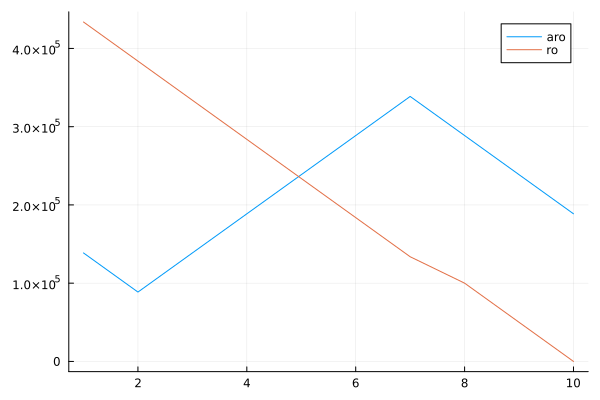

In [116]:
#plot for one state different premiums, the over all premiums are the same 
i= 23 
plot(x=range(1,10,10), [P_aro[i,:], P_ro[i,:]], labels=["aro" "ro"])

In [128]:
#adding a penalty term to the beta's 
function solve_aro_2(i, gamma2)
    gamma1 = 50000
    T1= 10 
    surplus = 1000 #this is delta 

    #for now let's solve it for one state i 
    c1 =  T1*mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10) #c1 is a vector, where c1[i] is the ith state value 
    c2 = -T1*mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)

    #try decompose into small models 
    println(c1, c2)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 300)


    # VARIABLES: premium for the next 10 years 
    @variable(model, alpha[1:T1]);  #P_i,t is the premium at state i in time t 
    @variable(model, beta[1:(T1-1)]>=0.00001 ); #explicitly set beta to be non-negative 

    @variable(model, omega); 


    #Epigraph formulation of the objective value 
    @objective(model, Min, omega)

    @variable(model, s11>=0);
    @variable(model, s12>=0);

    @constraint(model, epigraph, 
        sum(alpha[t] for t = 1:T1) + (c1*s11+c2*s12)  <= omega ); 

    for t=1:(T1-1)
        @constraint(model, 
            s11-s12 >= (T1-t)*beta[t]);  
    end 

    @constraint(model, s11 - s12 >=0); 

    # surplus constraint 
    @variable(model, s21>=0);
    @variable(model, s22>=0);

    @constraint(model, surplus, 
        -sum(alpha[t] for t = 1:T1) + (c1*s21+c2*s22)  <= -surplus  ); 

    for t=1:(T1-1)
        @constraint(model, 
            s21-s22 >= 1-(T1-t)*beta[t]);  
    end 

    @constraint(model, s21 - s22 >=1); 


    #slowly varying constraints 
    #for some t, and hence S1, S2 are vectors of size T 
    @variable(model, s31[2:T1] >=0)
    @variable(model, s32[2:T1] >=0)

    for t=2:T1
        @constraint(model,
            alpha[t] - alpha[t-1] + (c1*s31[t]+c2*s32[t]) <= gamma1 ) 
        @constraint(model,
            s31[t] - s32[t] >= beta[t-1])
    end 

    #slowly varying 2 
    @variable(model, s41[2:T1] >=0)
    @variable(model, s42[2:T1] >=0)

    for t=2:T1 
        @constraint(model,
            -(alpha[t] - alpha[t-1]) + (c1*s41[t]+c2*s42[t]) <= gamma1 ) 
        @constraint(model,
            s41[t] - s42[t] >= -beta[t-1])
    end 

    #positive l_i constraint 
    @variable(model, s51[2:T1] >=0)
    @variable(model, s52[2:T1] >=0)

    for t=2:T1-1
        @constraint(model, -alpha[t] + (c1*s51[t]+c2*s52[t]) <= 0 ) 
        for tao = 1:t-1
            @constraint(model, s51[t] - s52[t] >= -beta[tao])
        end 
    end 

    @constraint(model, alpha[1]>=0)

    optimize!(model)
    return JuMP.value.(alpha), JuMP.value.(beta)
end 



solve_aro_2 (generic function with 1 method)

In [129]:
a2,b2 = solve_aro_2(1, 0.8)

1.1460303646754543e81.413757930703327e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0x03c4715a
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-05, 1e-05]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 94 rows and 68 columns
Presolve time: 0.00s
Presolved: 9 rows, 18 columns, 34 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1461435e+08   1.431315e+07   0.000000e+00      0s
       8    1.1461435e+08   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.00 seconds
Optimal objective  1.146143507e+08

User-callback calls 46, time 

([1.1675518249791011e7, 1.1625518249791011e7, 1.1575518249791011e7, 1.1525518249791011e7, 1.1475518249791011e7, 1.1425518249791011e7, 1.1375518249791011e7, 1.1325518249791011e7, 1.1275518249791011e7, 1.1324372219426336e7], [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5])

In [133]:
p_i_3 = recover_P(1, a2, b2)
sum(p_i_3) - sum(P_aro[1,:])

2001.948146790266

In [127]:
#I'm here 
#why are the beta's always zero?? Perhaps this extra degree of freedom is not necessary??

In [45]:
# #let's try deterministic approach with gamma2=0 

# #Let's try solving for just one i: 
# gamma2 = 0  
# gamma1 = 50000 
# T1= 10 
# model = Model(Gurobi.Optimizer)
# set_optimizer_attribute(model, "TimeLimit", 60)


# # VARIABLES: premium for the next 10 years 
# @variable(model, p_i[1:T1]>=0);  #P_i,t is the premium at state i in time t 
# @variable(model, omega); 

# surplus = 1000 #this is delta 

# #Epigraph formulation of the objective value 
# @objective(model, Min, omega)

# @constraint(model, epigraph, 
#     sum(p_i[t] for t = 1:T1)  <= omega ); 
# @constraint(model, surplus,
#     sum(p_i[t] for t = 1:T1) - sum(l_i[t] for t = 1:T1) >= surplus)

# for t=2:T1
#     @constraint(model, p_i[t] - p_i[t-1] <= gamma1)
#     @constraint(model, p_i[t-1] - p_i[t] <= gamma1)
# end 

# optimize!(model)


Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 11 columns and 57 nonzeros
Model fingerprint: 0xfb73e0dd
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 2e+06]
Presolve removed 10 rows and 1 columns
Presolve time: 0.00s
Presolved: 10 rows, 19 columns, 37 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.336624e+06   0.000000e+00      0s
      10    2.3366245e+06   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds
Optimal objective  2.336624492e+06

User-callback calls 38, time in user-callback 0.00 sec


In [46]:
P_i2 = value.(p_i) 
sum(P_i2)
println(P_i2)

[458662.44921052625, 408662.44921052625, 358662.44921052625, 308662.44921052625, 258662.44921052625, 208662.44921052625, 158662.44921052625, 108662.44921052625, 58662.44921052625, 8662.449210526247]


In [47]:
# T1= 10 
# P_aro = Matrix{Float64}(undef,N,T1);  
# for i=1:N 
#     alpha_i, beta_i = solve_aro(i); 
#     P_aro[i,:] = recover_P(i, alpha_i, beta_i); 
# end 

LoadError: MethodError: no method matching solve_aro(::Int64)
[0mClosest candidates are:
[0m  solve_aro(::Any, [91m::Any[39m) at In[29]:2

In [48]:
P_aro[1,:]

10-element Vector{Float64}:
   0.0
   2.649374388239057e180
   8.2e-322
   5.0e-324
   2.1219957905e-314
   0.0
 NaN
 NaN
   6.9438428020277e-310
   0.0

In [23]:
#check if actual loss lives in the CLT uncertainty set:
i=1
gamma2= 0 

lower = - mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)
upper = mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)
sum_i = sum(act_loss[i,:])

if (lower <= sum_i) & (sum_i <= upper)
    println("lives in U")
elseif  (sum_i < lower) 
    println("less")
elseif (sum_i > upper)
    println("more")
end 

more


In [63]:
# gamma2 = 0.8 
# slope = 1/maximum(P_hist)
# P_ro = solve_ro2(gamma2, slope)
# P_ml = solve_ro3(gamma2, slope) #1/l_max 

FLFloat32[4.585367f6, 8.713942f6, 1.2693365f7, 1.6570976f7, 2.0581366f7, 2.4463612f7, 2.8577836f7, 3.2046528f7, 3.4200836f7, 3.616406f7]

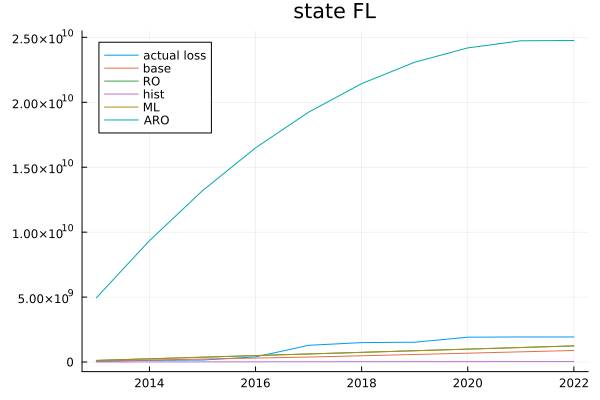

In [127]:
x = time_list[end-9:end] 

i=4 
print(state_list[i])

#crop P_hist to the last 10 years only 
P_hist2 = P_hist[:, end-9:end]

act = cumsum(act_loss[i,:])
base = cumsum(P_base[i,:])
RO= cumsum(P_ro[i,:])
ML = cumsum(P_ml[i,:])
hist = cumsum(P_hist2[i,:])
ARO = cumsum(P_aro[i,:])
print(hist)
plot(x, [act,  base, RO, hist, ML, ARO], label=["actual loss" "base" "RO" "hist" "ML" "ARO"], title="state $(state_list[i])")

In [130]:
sum(P_aro)- sum(act_loss)

5.281744881421229e11

## try debugging 

In [44]:
gamma2

0

In [35]:
function solve_aro_3(i, gamma2)
    gamma1 = 50000
    T1= 10 
    surplus = 1000 #this is delta 

    #for now let's solve it for one state i 
    c1 =  T1*mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10) #c1 is a vector, where c1[i] is the ith state value 
    c2 = -T1*mean_hist[i] .+ gamma2.*std_hist[i]*sqrt(10)

    #try decompose into small models 
    println(c1, c2)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "TimeLimit", 300)


    # VARIABLES: premium for the next 10 years 
    @variable(model, alpha[1:T1]);  #P_i,t is the premium at state i in time t 
    @variable(model, beta[1:(T1-1)]);

    @variable(model, omega); 


    #Epigraph formulation of the objective value 
    @objective(model, Min, omega)

    @variable(model, s11>=0);
    @variable(model, s12>=0);

    @constraint(model, epigraph, 
        sum(alpha[t] for t = 1:T1) + (c1*s11+c2*s12)  <= omega ); 

    for t=1:(T1-1)
        @constraint(model, 
            s11-s12 >= (T1-t)*beta[t]);  
    end 

    @constraint(model, s11 - s12 >=0); 

    # surplus constraint 
    @variable(model, s21[1:3]>=0);
    @variable(model, s22[1:3]>=0);
    T_list = [3,5,10]

    for i = 1:3
        TT = T_list[i]
        @constraint(model,
            -sum(alpha[t] for t = 1:TT) + (c1*s21[i]+c2*s22[i])  <= -surplus  ); 

        for t=1:(TT-1)
            @constraint(model, 
                s21[i]-s22[i] >= 1-(TT-t)*beta[t]);  
        end 

        @constraint(model, s21[i] - s22[i] >=1); 
    end 

    #slowly varying constraints 
    #for some t, and hence S1, S2 are vectors of size T 
    @variable(model, s31[2:T1] >=0)
    @variable(model, s32[2:T1] >=0)

    for t=2:T1
        @constraint(model,
            alpha[t] - alpha[t-1] + (c1*s31[t]+c2*s32[t]) <= gamma1 ) 
        @constraint(model,
            s31[t] - s32[t] >= beta[t-1])
    end 

    #slowly varying 2 
    @variable(model, s41[2:T1] >=0)
    @variable(model, s42[2:T1] >=0)

    for t=2:T1 
        @constraint(model,
            -(alpha[t] - alpha[t-1]) + (c1*s41[t]+c2*s42[t]) <= gamma1 ) 
        @constraint(model,
            s41[t] - s42[t] >= -beta[t-1])
    end 

    #positive l_i constraint 
    @variable(model, s51[2:T1] >=0)
    @variable(model, s52[2:T1] >=0)

    for t=2:T1-1
        @constraint(model, -alpha[t] + (c1*s51[t]+c2*s52[t]) <= 0 ) 
        for tao = 1:t-1
            @constraint(model, s51[t] - s52[t] >= -beta[tao])
        end 
    end 

    @constraint(model, alpha[1]>=0)

    optimize!(model)
    return value.(alpha), value.(beta)
end  

2.335624492105263e6-2.335624492105263e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113 rows, 82 columns and 376 nonzeros
Model fingerprint: 0xe29880d6
Coefficient statistics:
  Matrix range     [1e+00, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 45 rows and 61 columns
Presolve time: 0.00s
Presolved: 68 rows, 27 columns, 183 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      40    3.0295318e+06   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds
Optimal objective  3.029531848e+06

User-callback calls 74, time in user-callback 0.00 sec


In [36]:
value.(beta)

9-element Vector{Float64}:
 0.032963220951612304
 0.03708362357056383
 0.04238128408064437
 0.04944483142741846
 0.059333797712902155
 0.07416724714112768
 0.032963220951612304
 0.032963220951612304
 0.29666898856451074

In [71]:
#Putting everything together to solve for P 
T1= 10 
gamma2 = 0 

P_aro3 = Matrix{Float64}(undef,N,T1); 
Beta = Matrix{Float64}(undef,N,T1-1);  
Alpha = Matrix{Float64}(undef,N,T1);   
for i=1:N 
    alpha_i, beta_i = solve_aro_3(i, gamma2); 
    Beta[i,:] = beta_i; 
    Alpha[i,:] = alpha_i; 
    P_aro3[i,:] = recover_P(i, alpha_i, beta_i); 
end 

5.6594639268421054e7-5.6594639268421054e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113 rows, 82 columns and 376 nonzeros
Model fingerprint: 0xa3173dbd
Coefficient statistics:
  Matrix range     [1e+00, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 45 rows and 61 columns
Presolve time: 0.00s
Presolved: 68 rows, 27 columns, 183 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      39    7.9771157e+07   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds
Optimal objective  7.977115652e+07

User-callback calls 73, time in user-callback 0.00 sec
2.335624492105263e6-2.335624492105263e6
Academic license - for non-commercial

3.391861401928947e9-3.391861401928947e9
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113 rows, 82 columns and 376 nonzeros
Model fingerprint: 0xa54bae7f
Coefficient statistics:
  Matrix range     [1e+00, 3e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 45 rows and 61 columns
Presolve time: 0.00s
Presolved: 68 rows, 27 columns, 183 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      39    4.7991484e+09   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds
Optimal objective  4.799148360e+09

User-callback calls 77, ti

5.6509565199999996e7-5.6509565199999996e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113 rows, 82 columns and 376 nonzeros
Model fingerprint: 0x3b5fef28
Coefficient statistics:
  Matrix range     [1e+00, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 45 rows and 61 columns
Presolve time: 0.00s
Presolved: 68 rows, 27 columns, 183 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      44    7.9650777e+07   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds
Optimal objective  7.965077736e+07

User-callback calls 77, time in user-callback 0.00 sec
1.2666287763157894e6-1.2666287763157894e6
Academic license - for non-commerci

3.0586844152631577e7-3.0586844152631577e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113 rows, 82 columns and 376 nonzeros
Model fingerprint: 0xced70bbd
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 45 rows and 61 columns
Presolve time: 0.00s
Presolved: 68 rows, 27 columns, 183 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      45    4.2970323e+07   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.00 seconds
Optimal objective  4.297032345e+07

User-callback calls 79, time in user-callback 0.00 sec
1.905337033684211e7-1.905337033684211e7
Academic license - for non-commercial

2.7287790763157895e6-2.7287790763157895e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113 rows, 82 columns and 376 nonzeros
Model fingerprint: 0xdba8472e
Coefficient statistics:
  Matrix range     [1e+00, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 45 rows and 61 columns
Presolve time: 0.00s
Presolved: 68 rows, 27 columns, 183 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      40    3.5842041e+06   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds
Optimal objective  3.584204129e+06

User-callback calls 74, time in user-callback 0.00 sec
7.228665828947369e6-7.228665828947369e6
Academic license - for non-commercial

In [60]:
#Putting everything together to solve for P 
T1= 10 
gamma2 = 0.5 

P_aro = Matrix{Float64}(undef,N,T1); 
Beta = Matrix{Float64}(undef,N,T1-1);  
Alpha = Matrix{Float64}(undef,N,T1);   
for i=1:N 
    alpha_i, beta_i = solve_aro(i, gamma2); 
    Beta[i,:] = beta_i; 
    Alpha[i,:] = alpha_i; 
    P_aro[i,:] = recover_P(i, alpha_i, beta_i); 
end 

9.28498875178738e7-2.0339391018968314e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0xeb348cc9
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6114609e+36   6.512364e+30   1.611461e+06      0s
Extra simplex iterations after uncrush: 1
      33    9.2850888e+07   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds
Optimal objective  9.285088752e+07

User-callback calls 73, time in user-callback 0.00 sec
3.488432392455819e6-1.182816591754706

1.1120862191467437e8-5.699134518006244e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0xf62bb330
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2208063e+36   6.044351e+30   2.220806e+06      0s
Extra simplex iterations after uncrush: 1
      63    1.1120962e+08   0.000000e+00   0.000000e+00      0s

Solved in 63 iterations and 0.00 seconds
Optimal objective  

1.088857032760251e9-1.015914737555384e8
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0x4b485546
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0699276e+37   1.111807e+31   3.069928e+07      0s
Extra simplex iterations after uncrush: 1
      85    1.0888580e+09   0.000000e+00   0.000000e+00      0s

Solved in 85 iterations and 0.00 seconds
Optimal objective  1

7.012989873969032e7-3.540203630767809e7
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0x3cf37d0a
Coefficient statistics:
  Matrix range     [1e+00, 7e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3815753e+36   4.443702e+30   1.381575e+06      0s
Extra simplex iterations after uncrush: 1
      51    7.0130899e+07   0.000000e+00   0.000000e+00      0s

Solved in 51 iterations and 0.00 seconds
Optimal objective  7.013089874e+07

User-callback calls 91, time in user-callback 0.00 sec
3.951200221659717e7-2.166168608866598

1.0122641584615283e7-5.070213673279453e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0xa03a50ac
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9802048e+35   4.830140e+30   1.980205e+05      0s
Extra simplex iterations after uncrush: 1
      63    1.0123642e+07   0.000000e+00   0.000000e+00      0s

Solved in 63 iterations and 0.00 seconds
Optimal objective  1.012364158e+07

User-callback calls 103, time in user-callback 0.00 sec
1.4143307453243723e7-6.595269094124

In [61]:
P_aro3[2,:] - P_aro[2,:]

10-element Vector{Float64}:
 938889.2872824264
 913429.552272866
 893152.2577121449
 757232.4002864463
 617016.1501268594
 466602.03076658933
 362032.4020486274
 218777.54096329643
  71220.07577671704
  20002.976579373877

In [56]:
a3,b3 = solve_aro_3(2, 0.5)

3.488432392455819e6-1.1828165917547063e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113 rows, 82 columns and 376 nonzeros
Model fingerprint: 0xe318dc14
Coefficient statistics:
  Matrix range     [1e+00, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 20 rows and 15 columns
Presolve time: 0.00s
Presolved: 93 rows, 67 columns, 400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      42    9.1392788e+06   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds
Optimal objective  9.139278832e+06

User-callback calls 80, time in user-callback 0.00 sec


([1.2428325265280083e6, 1.1643316666469825e6, 1.0822681992808285e6, 995624.2365766525, 902872.9467551139, 801571.3989692675, 700269.8511834211, 598968.3033975747, 497666.7556117283, 396365.2078258819], [0.024095755909836168, 0.0271077253985658, 0.030980257598360827, 0.0361436338647543, 0.04337236063770516, 0.04337236063770516, 0.04337236063770516, 0.04337236063770516, 0.04337236063770516])

In [50]:
solve_aro(2,0.1)

2.5661860721753743e6-2.1050629120351514e6
Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 103 rows, 78 columns and 342 nonzeros
Model fingerprint: 0x2dec6e98
Coefficient statistics:
  Matrix range     [1e+00, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 21 rows and 13 columns
Presolve time: 0.00s
Presolved: 82 rows, 65 columns, 373 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2015141e+34   4.786198e+30   4.201514e+04      0s
Extra simplex iterations after uncrush: 1
      56    2.5671861e+06   0.000000e+00   0.000000e+00      0s

Solved in 56 iterations and 0.00 seconds
Optimal objective  2.567186072e+06

User-callback calls 96, time in user-callback 0.00 sec


([41718.607217537414, 91718.60721753741, 141718.6072175374, 191718.60721753744, 241718.60721753744, 291718.6072175375, 341718.6072175375, 391718.6072175375, 441718.6072175375, 391718.6072175375], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [67]:
#try different gammas 
gamma2 = 0.8

function solve_ro(gamma2)
        gamma1 = 50000 
        T1= 10 
        surplus = 1000 #this is delta 
    
        #gamma determines L_star
        L_star = 10*mean_hist + gamma2*std_hist*sqrt(10); 

        model3 = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model3, "TimeLimit", 30)

        # VARIABLES: premium for the next 10 years 
        @variable(model3, P[1:N,1:T1] >=0);  #P_i,t is the premium at state i in time t 
    
        # each state premium covers state loss L* from the inner problem 
        for i = 1:N
            for TT in [3,5,10]
                @constraint(model3,
                    sum(P[i, t] for t = 1:TT) - L_star[i] >= surplus); 
            end 
        end 

        #slowly vary 
        @constraint(model3, slowly_vary[i=1:N, t=2:T1],
            P[i,t] - P[i, t-1] <= gamma1);
        @constraint(model3, slowly_vary2[i=1:N, t=2:T1],
            P[i,t-1] - P[i, t] <= gamma1)

        @objective(
                model3, Min, sum(P[i, t] for t = 1:T1, i = 1:N) 
            )

        optimize!(model3)
        P_ro = value.(P);   
    return P_ro 
end 

solve_ro (generic function with 1 method)

In [72]:
P_ro = solve_ro(0)

Academic license - for non-commercial use only - expires 2024-04-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1113 rows, 530 columns and 2862 nonzeros
Model fingerprint: 0x8533aa82
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 477 rows and 0 columns
Presolve time: 0.00s
Presolved: 636 rows, 1007 columns, 2385 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.193265e+10   0.000000e+00      0s
     573    3.5389098e+10   0.000000e+00   0.000000e+00      0s

Solved in 573 iterations and 0.00 seconds
Optimal objective  3.538909844e+10

User-callback calls 603, time in user-callback 0.00 sec


53×10 Matrix{Float64}:
      1.89152e7       1.88652e7  …  1.85652e7  1.85152e7      1.84652e7
      8.28875e5       7.78875e5     4.78875e5  4.28875e5      3.78875e5
      3.67825e8       3.67775e8     3.67475e8  3.67425e8      3.67375e8
      2.56652e8       2.56602e8     2.56302e8  2.56252e8      2.56202e8
      3.29635e7       3.29135e7     3.26135e7  3.25635e7      3.25135e7
      4.43175e7       4.42675e7  …  4.39675e7  4.39175e7      4.38675e7
      3.42282e6       3.37282e6     3.07282e6  3.02282e6      2.97282e6
      7.24306e7       7.23806e7     7.20806e7  7.20306e7      7.19806e7
      4.34728e8       4.34678e8     4.34378e8  4.34328e8      4.34278e8
      1.86885e7       1.86385e7     1.83385e7  1.82885e7      1.82385e7
      2.80837e7       2.80337e7  …  2.77337e7  2.76837e7      2.76337e7
      1.13067e9       1.13062e9     1.13032e9  1.13027e9      1.13022e9
      3.8541e7        3.8491e7      3.8191e7   3.8141e7       3.8091e7
      ⋮                          ⋱        

In [74]:
sum(P_ro - P_aro3)

1.772373418266777e10

In [3]:
#compare julia with python https://dataframes.juliadata.org/stable/man/comparisons/ 